# Places - The Soul of *Dubliners*

## Peng Wang

8/19/2019

Introduction to Computational Literary Analysis
UC-Berkeley, Summer 2019
Instructor: Jonathan Reeve

As we know, as a city novel, there are lots of specific real places in *Dubliners*. They may indicate where the characters live and move and what they talk and think. Thus, I presume that there is a strong link between those geographic information and the novel text. By learning about the distribution and center of the places or some text analyses in terms of place names, some motifs, styles and contents of the novel may be reflected. I had my first try.

### 1. Places in *Dubliners*

In [1]:
import folium
import pandas as pd
from zipfile import ZipFile
from sklearn.cluster import MiniBatchKMeans
import requests
import json
import collections
import spacy
%matplotlib inline
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import nltk
from nltk.corpus import stopwords 
import re
from string import digits
from gensim.models import word2vec
from nltk.corpus import sentiwordnet as sw
from nltk.corpus import wordnet as wn
from nltk.wsd import lesk
import math

In [2]:
nlp = spacy.load('en_core_web_lg')

In [3]:
dublinersUrl = "https://raw.githubusercontent.com/JonathanReeve/course-computational-literary-analysis/gh-pages/_texts/dubliners.md"
dubliners = requests.get(dublinersUrl).text

In [4]:
dublinersStories = dubliners.split('\n## ')
dublinersDoc = nlp(dubliners.replace('\n',' '))
dublinersDocs = [nlp(text.replace('\n',' ')) for text in dublinersStories]

In [5]:
stop_words = set(stopwords.words('english'))

In [6]:
chapter_places = {}
for pla in ['GPE','FAC','LOC']:
    chapter_places[pla] = [0]*15

In [7]:
titles = ['The Sisters',
 'An Encounter',
 'Araby',
 'Eveline',
 'After the Race',
 'Two Gallants',
 'The Boarding House',
 'A Little Cloud',
 'Counterparts',
 'Clay',
 'A Painful Case',
 'Ivy Day in the Committee Room',
 'A Mother',
 'Grace',
 'The Dead']

In [8]:
'''
The number of places for each chapter.
'''
places_chapter = []
placeAppear = {}
places_wholebook = []
for i in range(1,len(dublinersDocs)):
    for word in dublinersDocs[i].ents:
        for pla in ['GPE','FAC','LOC']:
            if word.label_ == pla:
                chapter_places[pla][i-1] += 1
                places_wholebook.append(word.text)
                if word.text not in placeAppear.keys():
                    placeAppear[word.text] = [i]
                else:
                    placeAppear[word.text].append(i)
    tmp = [(word.text, word.label_) for word in dublinersDocs[i].ents if word.label_ in ['GPE','FAC','LOC']]
    places_chapter.append(tmp)

In [9]:
maxtwo = {}                                 #find the two chapters of max GPE/FAC/LOC numbers
for key in chapter_places.keys():
    for i in range(2):
        a = chapter_places[key].index(max(chapter_places[key]))
        if i==0:
            maxtwo[key] = [a]
        else:
            maxtwo[key].append(a)
        chapter_places[key].remove(chapter_places[key][maxtwo[key][len(maxtwo[key])-1]])
#df = pd.DataFrame(chapter_places, index=titles).fillna(0).plot(kind='bar',title="Word Frequency")

In [10]:
for key in maxtwo.keys():
    print(key+'-------max-------')
    for index in maxtwo[key]:
        print(titles[index])

GPE-------max-------
The Dead
A Little Cloud
FAC-------max-------
Two Gallants
Grace
LOC-------max-------
The Dead
Two Gallants


There are three kinds of labels that represent places. "GPE" represents countries, cities, states; "FAC" represents buildings, airports, highways, bridges, etc; "LOC" represents Non-GPE locations, mountain ranges, bodies of water. I first got numbers of places appearing in each chapter. I discovered that the numbers of the places under the label "GPE" are remarkablely high in "A Little Cloud" and "The dead". It may because the large description of Gallaher's success outside Ireland and the couples' whole life experience. The places under the label "FAC" is high in "Two Gallants", because they were continuously walking along the street. 

In [11]:
'''
These are the words that are mistakenly labeled in the entity "place".
'''
mistakes = ['Academy','Lenehan','Aunt Julia','the moon','Kearneys','Kearney','Farrington','Crofton','Alphy','Galway','Bodley',"O'Madden Burke"]

In [12]:
placeMorethanOnce = {}      #get places more than once
for pl in placeAppear.keys():
    if len(set(placeAppear[pl])) >= 2 and pl not in mistakes:
        placeMorethanOnce[pl] = set(placeAppear[pl])

In [13]:
placeMorethanOnce

{'Gardiner Street': {2, 14},
 'the Canal Bridge': {2, 10},
 'Dublin': {2, 5, 7, 8, 10, 11, 12, 13, 15},
 'Belfast': {4, 10, 14},
 'England': {4, 5},
 'the North Wall': {4, 8},
 'Continent': {5, 8, 15},
 'Paris': {5, 8, 15},
 'Kingstown': {5, 11, 15},
 'France': {5, 15},
 'Dame Street': {5, 6},
 'Grafton Street': {5, 6, 14},
 'Ireland': {5, 8, 15},
 'Baggot Street': {6, 11},
 'Capel Street': {6, 8},
 "George's Street": {6, 11},
 'Westmoreland Street': {6, 14},
 'the Isle of Man': {7, 8},
 'Fleet Street': {7, 9},
 'London': {8, 9, 13, 14, 15},
 "O'Connell Bridge": {9, 15},
 'Sandymount': {9, 14},
 'Henry Street': {10, 15},
 'the Mansion House': {12, 13},
 'Glasgow': {14, 15}}

In [14]:
collections.Counter(places_wholebook).most_common(10)

[('Dublin', 36),
 ('London', 15),
 ('Paris', 13),
 ('Ireland', 6),
 ('Galway', 6),
 ('Grafton Street', 5),
 ('Lenehan', 5),
 ('Farrington', 5),
 ('Belfast', 4),
 ('Continent', 4)]

After removing the wrong words in "places" entity, I counted the places that appear more than once and appear most times in the novel. They are the comparatively significant places in *Dubliners*. To give reasonable interpretations about the results, I searched some places and found some relations with the novel contents. The analyses will be displayed in the following part. 

In [15]:
places_wholebook = list(set(places_wholebook))
for pla in mistakes:
    places_wholebook.remove(pla)

In [16]:
placeSents = []                      # get all the sentences including places
placeLabel = []
for sent in dublinersDoc.sents:
    placeinthissentence = []
    for place in places_wholebook:
        if place in str(sent):
            placeinthissentence.append(place)
            if sent not in placeSents: 
                placeSents.append(sent)  
    if placeinthissentence:
        placeLabel.append(placeinthissentence)

In [17]:
streetSentence = []
for sent in dublinersDoc.sents:
    for word in sent:
        if word.text.lower() == 'street':
            streetSentence.append(sent)

In [18]:
words = []                           #get all the words in placeSents.
for text in [placeSents,dublinersDoc.sents,streetSentence]:
    words.append([])
    for sent in text:
        words[len(words)-1].extend([word.lemma_.lower() for word in sent if word.text not in stop_words])
placeWords,dublinersWords,streetWords = words

In [19]:
placeCounts = [collections.Counter(placeWords),collections.Counter(dublinersWords),collections.Counter(streetWords)]
length = [len(placeWords), len(dublinersWords), len(streetWords)]
placeCountsDF = pd.DataFrame(placeCounts, 
                     index=["place", "whole","street"]).fillna(0).T
proportions = placeCountsDF / length
proportions['placeunique'] = proportions['place'] - proportions['whole']
proportions.sort_values('placeunique', ascending=False)[:20]      # find unique words in placeSents

,place,whole,street,placeunique
street,0.015209,0.001902,0.076105,0.013308
dublin,0.010139,0.000746,0.000818,0.009394
house,0.007098,0.001939,0.007365,0.005159
go,0.010139,0.005630,0.009820,0.004509
london,0.004056,0.000298,0.000818,0.003757
",",0.070215,0.066460,0.052373,0.003755
paris,0.003295,0.000242,0.000000,0.003053
along,0.003549,0.000951,0.004910,0.002598
walk,0.004056,0.001510,0.013093,0.002546
corner,0.003042,0.000634,0.010638,0.002408


Then I tried to find the distinctive words in the sentences including places and above is my result. We can see that "street" appears at a high frequency, so does "house". The word "walk" also appears often. This describes a picture that confused and helpless men and women wandered in the streets in Dublin aimlessly. The whole Ireland sunk in disappointment and displeasure. It is related to the theme "paralysis".

In [20]:
proportions['streetunique'] = proportions['street'] - proportions['whole']
proportions.sort_values('streetunique', ascending=False)[:20]              #find unique words in street sententces

,place,whole,street,placeunique,streetunique
street,0.015209,0.001902,0.076105,0.013308,0.074203
walk,0.004056,0.001510,0.013093,0.002546,0.011583
's,0.008112,0.006674,0.018003,0.001438,0.011329
corner,0.003042,0.000634,0.010638,0.002408,0.010004
-,0.009379,0.007737,0.013912,0.001642,0.006175
turn,0.002535,0.001529,0.007365,0.001006,0.005836
towards,0.002788,0.001100,0.006547,0.001688,0.005447
house,0.007098,0.001939,0.007365,0.005159,0.005426
go,0.010139,0.005630,0.009820,0.004509,0.004190
one,0.005577,0.004157,0.008183,0.001419,0.004026


In [21]:
for sent in streetSentence:
    if "window" in str(sent):
        print(sent)

I walked away slowly along the sunny side of the street, reading all the theatrical advertisements in the shopwindows as I went.
When we returned to the street light from the kitchen windows had filled the areas.
From the front window I saw my companions playing below in the street.
All the windows of the boarding house were open and the lace curtains ballooned gently towards the street beneath the raised sashes.
Modern business methods had spared him only so far as to allow him a little office in Crowe Street, on the window blind of which was written the name of his firm with the address---London, E. C.
A ghostly light from the street lamp lay in a long shaft from one window to the door.


Getting the inspiration, I tried to count the distinctive words in the sentences which includes "street". Besides some verbs, prepositions and street names, I found the words "window" very intereting. 
"Window" serves as a symbol in Dubliners. Windows mark the threshold between indoor space and outdoor space. In most part of "Eveline", Eveline sat beside the window and reflected whether to escape from Dublin. Gabriel also went to the window to think. They both looked outside. And in "The Sisters", the narrator looked into the window each night, waiting for signs of Father Flynn’s death (Jill, 2010). Windows provide people chances to observe lives of themselves and others. It is a symbol of empathy. 

In [22]:
placeAdj = []                # find most frequent adjectives in place sentences.
for sent in placeSents: 
    #if 'great' in str(sent):
    #    print(sent)
    for word in sent: 
        if 'JJ' in word.tag_: 
            placeAdj.append(word.lemma_)
collections.Counter(placeAdj).most_common(20)

[('little', 17),
 ('young', 12),
 ('old', 10),
 ('many', 9),
 ('great', 9),
 ('good', 7),
 ('white', 5),
 ('other', 5),
 ('small', 5),
 ('brown', 4),
 ('big', 4),
 ('short', 4),
 ('dark', 4),
 ('true', 4),
 ('full', 4),
 ('quiet', 3),
 ('fat', 3),
 ('few', 3),
 ('poor', 3),
 ('gaunt', 3)]

Then I count the most frequent adjectives in the sentences including places. Then I had an insight into the concordances of a few words. The word "little", "young" and "old" are used to describe people. It can be discovered that James Joyce liked to depict all kinds of people. "Great" is often related to places. Words like "brown" and "dark" created a depressive atmosphere, which quite fit the theme. 

### 2. Visualization on map and other analyses

In [23]:
kmz = ZipFile("mappingdublinersearth.kmz", 'r')             #The already downloaded kmz file.
kml = kmz.open('doc.kml', 'r').read()

In [24]:
kmlstr = str(kml)[1:]                                       # get the all geographic information.
aaa = kmlstr.replace('\\t','  ').split('\\n')
places = []
coordinates = {}
titles = []
routes = []
place_and_co = {}
for i in range(len(aaa)):
    if '<name>' in aaa[i]:
        if '&quot' in aaa[i]:
            storyName = aaa[i][16:-13]
            if storyName not in coordinates.keys():
                coordinates[storyName] = {}
                titles.append(storyName)
        else:
            placeName = aaa[i][12:-7].replace('&apos;',"'")
            places.append(placeName)
            
    if '<coordinates>' in aaa[i]:
        if placeName not in coordinates[storyName].keys():
            co = aaa[i][21:-16]
            co = co.split(',')
            if co[0] and len(co) == 2 or len(co) == 3:
                coordinates[storyName][placeName] = [float(co[1]),float(co[0])]
                place_and_co[placeName] = (float(co[1]),float(co[0]))
            if co[0]=='':
                routes.append(aaa[i+1])

Then, to better visualize the analyses related to places, I found a project online called *Mapping Dubliners* which collects all the places in *Dubliners* on google map(Jasmine, 2012). Because there are some places that have their names changed throughout the last century and checking it one by one seems a great work, I downloaded the KMZ file and unzipped it. After getting to know the pattern where the chapters, place names, latitudes and longitude are written, I wrote the code to get all the geographic information. This include the place coordinates and the routes the character went along in each chapter. 

In [25]:
graphSents = []
placeLabel = []
for sent in dublinersDoc.sents:
    placeinthissentence = []
    for place in places:
        if place.lower() in str(sent).lower():
            placeinthissentence.append(place)
            if sent not in graphSents: 
                graphSents.append(sent)  
    if placeinthissentence:
        placeLabel.append(placeinthissentence)

In [26]:
lemmaList = []
for sent in graphSents: 
    sentLemmaList = []
    for w in sent: 
        if (not w.is_stop) and (not w.is_punct) and (not w.is_space) and (w.pos_ is not 'PROPN'): 
            sentLemmaList.append((w.lemma_, w.pos_))
    lemmaList.append(sentLemmaList)

In [27]:
placeScores = {}                                   #sentiment analysis
placeSentScores = []
for i in range(len(lemmaList)): 
    scores = []
    for word, pos in lemmaList[i]: 
        synPos = pos.lower()[0]
        if synPos not in ['a', 'n', 'v']:
            continue
        synsets = list(sw.senti_synsets(word, synPos))
        if (type(synsets) == list) and len(synsets)>0:
            synset = synsets[0]
            score = synset.pos_score() - synset.neg_score()
            scores.append(score)
    if len(scores)>0: 
        avgScores = sum(scores) / len(scores)
        placeSentScores.append(avgScores)
        for pp in placeLabel[i]:
            if pp in placeScores.keys():
                placeScores[pp].append(avgScores)
            else:
                placeScores[pp] = [avgScores]

In [28]:
for place in placeScores.keys():
    placeScores[place] = sum(placeScores[place])/len(placeScores[place])

In [29]:
df = pd.DataFrame([[place for place in placeScores.keys()],[score for score in placeScores.values()]],index=['place','score']).T

In [30]:
df = df.sort_values('score',ascending=False)

In [31]:
sentColors = ['maroon','firebrick','indianred','lightcoral','red','salmon','mistyrose']

In [32]:
coos = []                                 # mark the degree of sentiment on the map
c1 = []
for i in range(len(df)):
    a = place_and_co[df['place'][i]]
    coos.append(a)
c = []
for color in sentColors:
    for i in range(19):
        c.append(color)
c = c[:131]

In [33]:
color={'The Sisters':'teal',
       'An Encounter':'orange',
       'Araby':'yellow',
       'Eveline':'green',
       'After the Race':'cyan',
       'Two Gallants':'blue',
       'The Boarding House':'purple',
       'A Little Cloud':'deepskyblue',
       'Counterparts':'grey',
       'Clay':'black',
       'A Painful Case':'white',
       'Ivy Day in the Committee Room':'greenyellow',
       'A Mother':'orchid',
       'Grace':'lavender',
       'The Dead':'olive'
        }

In [34]:
spots = []                                                # For drawing the routes.
for route in routes:
    tmp = []
    route_ = route.strip().split(' ')
    for spott in route_:
        spot = spott.split(',')
        tmp.append((float(spot[1]),float(spot[0])))
    spots.append(tmp)

In [35]:
'''
caculate the average distance of places.
'''
def averageDistance(pointList):
    sumd = 0
    for i in range(len(pointList)):
        for j in range(i+1,len(pointList)):
            sumd += math.sqrt((pointList[i][0]-pointList[j][0])*(pointList[i][0]-pointList[j][0])+(pointList[i][1]-pointList[j][1])*(pointList[i][1]-pointList[j][1]))
    ad = sumd/((len(pointList)-1)*(len(pointList))/2)
    return ad

In [36]:
titles = ['The Sisters',
 'An Encounter',
 'Araby',
 'Eveline',
 'After the Race',
 'Two Gallants',
 'The Boarding House',
 'A Little Cloud',
 'Counterparts',
 'Clay',
 'A Painful Case',
 'Ivy Day in the Committee Room',
 'A Mother',
 'Grace',
 'The Dead']
'''
Only consider the places in Ireland to cluster the places. Cluster the places in each chapter and caculate
the average distance of each chapter's places.
'''
centers = []
centerdict = {}
print("-----------Average Distances---------------")
for title in titles:
    clusterList = []
    distanceList = []
    for coordinate in coordinates[title].values():
        if coordinate[0]>51.478647 and coordinate[0]<55.126407 and coordinate[1]>-10.205399 and coordinate[1]<-6.094833:
            clusterList.append((coordinate[0],coordinate[1]))
        distanceList.append((coordinate[0],coordinate[1]))
    d = averageDistance(distanceList)
    print(title, d)
    clu = MiniBatchKMeans(n_clusters = 1)
    center = clu.fit(clusterList)
    centroids = clu.cluster_centers_ 
    centerdict[title] = centroids
    centers.append(centroids)
print("----------------Centers------------------")
i = 0
for center in centers:
    print(titles[i],center[0])
    i += 1

-----------Average Distances---------------
The Sisters 25.621228830596564
An Encounter 0.018503123949435415
Araby 0.00832716050162075
Eveline 86.64733817360715
After the Race 24.58115788830201
Two Gallants 0.012845340277125018
The Boarding House 1.3274940369085324
A Little Cloud 7.158462431771514
Counterparts 0.9917364633864718
Clay 0.4432111209382733
A Painful Case 4.479966666374251
Ivy Day in the Committee Room 0.01204869086956131
A Mother 1.5417803745696987
Grace 0.7292253519309464
The Dead 4.569597188590773
----------------Centers------------------
The Sisters [53.34608137 -6.25364395]
An Encounter [53.35283822 -6.24022505]
Araby [53.35320677 -6.25016614]
Eveline [53.34456383 -6.25577373]
After the Race [53.33021191 -6.24922484]
Two Gallants [53.34212191 -6.26033497]
The Boarding House [53.35414221 -6.25730788]
A Little Cloud [53.34813589 -6.26264709]
Counterparts [53.34460626 -6.25854659]
Clay [53.34802275 -6.25513819]
A Painful Case [53.3274838  -6.33196548]
Ivy Day in the Commi

In [37]:
'''
Get the point that the stories mostly centered.
'''
all_ = []
for title in titles:
    for coordinate in coordinates[title].values():
        if coordinate[0]>53.254239 and coordinate[0]<53.414464 and coordinate[1]>-6.425699 and coordinate[1]<-6.112838:
            all_.append((coordinate[0],coordinate[1]))
clu = MiniBatchKMeans(n_clusters = 1)
center = clu.fit(all_)
centroids = clu.cluster_centers_ 
print(centroids)

[[53.34369098 -6.25813162]]


In [38]:
from folium import plugins               #Visualize on the map.
world_map = folium.Map()
places = folium.map.FeatureGroup()
sentplace = folium.map.FeatureGroup()
pls = plugins.MarkerCluster()
routesColor = ['orange','yellow','cyan','cyan','blue','olive','deepskyblue','grey','black','lavender','olive']

for i in range(len(spots)):
    for j in range(len(spots[i])-1):
        places.add_child(folium.PolyLine([(spots[i][j][0], spots[i][j][1]),(spots[i][j+1][0], spots[i][j+1][1])],color=routesColor[i]))

for i in centerdict.keys():
    places.add_child( folium.CircleMarker([centerdict[i][0][0], centerdict[i][0][1]], radius=20, # define how big you want the circle markers to be 
                                             color=color[i], fill=True, fill_color=color[i], fill_opacity=0.2, popup=i ))

for chapter in coordinates.keys():
    first = 0
    for place in coordinates[chapter].keys():
        if first == 0:
            places.add_child( folium.CircleMarker( [coordinates[chapter][place][0], coordinates[chapter][place][1]], radius=7, # define how big you want the circle markers to be 
                                             color=color[chapter], fill=False,popup=chapter+':'+'first one '+place ) )
            pls.add_child( folium.CircleMarker( [coordinates[chapter][place][0], coordinates[chapter][place][1]], radius=10, # define how big you want the circle markers to be 
                                             color=color[chapter], fill=False) )
            
        elif first == len(coordinates[chapter]) - 1:
            places.add_child( folium.CircleMarker( [coordinates[chapter][place][0], coordinates[chapter][place][1]], radius=7, # define how big you want the circle markers to be 
                                             color=color[chapter], fill=True, fill_color=color[chapter], fill_opacity=1,popup=chapter+':'+'last one '+place ) )
            pls.add_child( folium.CircleMarker( [coordinates[chapter][place][0], coordinates[chapter][place][1]], radius=10, # define how big you want the circle markers to be 
                                             color=color[chapter], fill=False) )
            
        else:
            places.add_child( folium.CircleMarker( [coordinates[chapter][place][0], coordinates[chapter][place][1]], radius=3, # define how big you want the circle markers to be 
                                             color=color[chapter], fill=True, fill_color=color[chapter], fill_opacity=first*1/(len(coordinates[chapter])-1),popup=chapter+':'+place ) ) 
            pls.add_child( folium.CircleMarker( [coordinates[chapter][place][0], coordinates[chapter][place][1]], radius=3, # define how big you want the circle markers to be 
                                             color=color[chapter], fill=False) ) 
        first += 1

for i in range(len(coos)):
    sentplace.add_child( folium.CircleMarker( [coos[i][0], coos[i][1]], radius=15, # define how big you want the circle markers to be 
                                             color=c[i], fill=True, fill_color=c[i], fill_opacity=0.5  ) )
 
        
irish_map = folium.Map(location=[53.34346921, -6.25834564], zoom_start=12)
irish_map.add_child(folium.Marker([53.34346921, -6.25834564], popup='center'))
irish_map.add_child(sentplace)
irish_map.add_child(places)
#irish_map.add_child(pls)
#sent_map.add_child(sentplace)

Combined with this graph, I will explain what I have done. 

First, I got one exact point which stories mostly center using cluster methods. Then get the center points of each chapter. Because other countries may be too far and taking them into account may not be representative, so I just included places in Ireland and considered the other countries separately. The larger circles are the center points of places in each chapter. Each chapter has one different color. 

We can see that "Grace", "A Little Cloud", "Clay", "The Sisters", "Eveline", "Two Gallants", "Counter Parts" surrounded the center. Places in "An Encounter" are comparatively far, maybe because they are going on a adventure. And there they can hear the noise of industrial manufacture, "watching the working of cranes and engines and often being shouted at for our immobility by the drivers of groaning carts." Also, "After the Race" centers at the south because they drove till the Kingstown Habour in the south. From those center points, we can see the general area of the characters' activities in each chapter.

I also marked and analyzed the first and last places of one chapter. Some of them quite fit the routes. In terms of the routes, the routes in "An Encounter" and "Two Gallants" are in circles(Madeleine,2016). It may indicate the lack of direction in the hearts of characters or the pursue for freedom repressed by reality.

In terms of other countries besides Ireland, they quite reflect the content. Merely in the time of the story, the main characters did not go abroad. So those places are related to their background, past experience and future imagination. For example, some places in "After the Race" are in Europe and North America, They are the birthplaces of Jimmy’s rich foreign companions. And in "Eveline", some places in Argentina and Canada are where Frank used to live and travel to, thus are unknown to Eveline. In "A Painful Case", Mr.Sinico lived in Holland when his wife died. In "The Dead", the couple usually went on vacation in some countries in Europe. 

For Eveline and Jimmy, they all wanted to be free of the restriction of their life and class, but finally failed, remained staying in Dublin. We can see the last places of their chapters are in Dublin.

As I mentioned and displayed before, there are a few places appearing more than once in *Dubliners*. For example, the Stores where Eveline worked in. It is also mentioned in "Two Gallant" where Corley used to worked in. Belfast is a commercial center, which is mentioned in three stories as an more ideal and advanced place. Grafton Street and Westmoreland Street where many routes went through and several events happened. Westmoreland serves as a link from north to south in *Dubliners*(Jasmine, 2012). The Hill of Howth, has long been a popular retreat for picnicers, hikers, and fishers, mentioned in both "Eveline" and "A Mother" as a leisure destination, especially important in Eveline's recall of her mother. North Wall, in both "Eveline" and "A Little Cloud", offers the miserable characters the chance to escape from Dublin, but it is also an intangible boundary.

The places repeatedly appear make this novel more authentic.

Then I did some sentiment analysis within the sentences which include place names. I rank the sentiment scores from high to low, along with red colors of a sequence of color depth. I found out that, the more central it is, the more lighter colors appear, which means the more negative the sentence is. It maybe because many characters in Dubliners are lower class and almost all the characters suffered frustration, desperation, loneliness, except for the front period of "An Encounter" and "Araby". We can see including "The Sisters", in the stories about children, the moods are lighter. In the city enter, there are more pressure, comparisons, responsibilities, so it is more repressive. People wanted to escape from the center. Places outside center of Dublin always carried the ideal imagination and hope or unforgettable recall of characters, so the colors are comparatively deeper. For example, in "Eveline", all the places outside the center of Ireland are with deep colors, both foreign countries and the Hill of Howth, which carried Eveline's good memory and hope. In "The Dead", almost all the places are in light color. The whole story is depressive.

Since the stories in *Dubliners* are chronologically arranged, I presumed that with the life experience growing, the places would be more widespread. I calculated the average distance of places in each chapter but found that there is no absolute connection between the range of the area and the life stage of the characters. The range of the places is more determined by the content of the chapter itself. 

### 3. Some word entities about place.

In [39]:
in_room = ['room','furnishing','building']
out_room = ['road','body_of_water','tract','geological_formation','physical_phenomenon']
travel = ['travel']
definition = [0,1,0,0,0,0,0,0,0]

In [40]:
deff = 0                     #Use the wordnet to get all the words.
alltheWords = []
for words in [in_room,out_room,travel]:
    for i in range(len(words)):
        if len(words)==1:
            wordSyns = wn.synsets(words[i],pos='v')
        else:
            wordSyns = wn.synsets(words[i],pos='n')
        queue = []
        allWords = []
        def getAllWords(word):
            queue.extend(word.hyponyms())                      
            allWords.extend(word.hyponyms())                   # add first layer to lists allWords and queue
            while len(queue) > 0:                              # if list queue has at least one element
                if len(queue[0].hyponyms()) > 0:               # if there is color A deeper than the color queue[0], add color A to lists allWords and queue.
                    queue.extend(queue[0].hyponyms())
                    allWords.extend(queue[0].hyponyms())
                del queue[0]                                   # delete the first element in list queue.
        getAllWords(wordSyns[definition[deff]])
        deff += 1
        alltheWords.append([str(word).replace('_',' ')[8:-7] for word in allWords])      # just take the letters describing the color.

In [41]:
inroomWords = alltheWords[:3]
outroomWords = alltheWords[3:8]
travelWords = [alltheWords[8]]
inroomWords[0].append('room')
inroomWords[1].remove('appointment')
outroomWords[0].append('road')
inWords = []
outWords = []
for words in inroomWords:
    inWords.extend(words)
for words in outroomWords:
    outWords.extend(words)

In [42]:
geowords = inroomWords
geowords.extend(outroomWords)
geo = in_room
geo.extend(out_room)

In [43]:
story_inorout = {}      #To calculate the word frequency of eight categories.
for place in geo:
    story_inorout[place] = []
chapterPlace = []
for i in range(len(geowords)):
    chapterroom = []
    for chapter in dublinersDocs:
        num = 0
        sum_ = 0
        for sent in chapter.sents:
            sum_ += 1
            place_has = 0
            for word in sent:
                if word.lemma_ in geowords[i] and 'NN' in word.tag_ and word.text!='head':
                    #print(word.text,end=' ')
                    place_has = 1
            if place_has == 1:
                num += 1
        #print('\n')
        chapterroom.append(num/sum_)
    story_inorout[geo[i]] = chapterroom[1:]

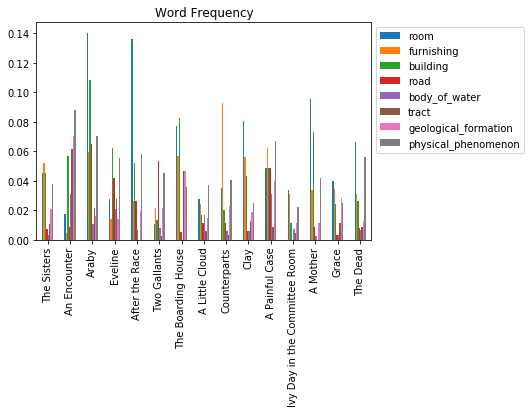

In [44]:
df = pd.DataFrame(story_inorout, index=titles).fillna(0).plot(kind='bar',title='Word Frequency').legend(bbox_to_anchor=(1.0, 1.0))

In [45]:
lemmatizer=WordNetLemmatizer()   # To calculate the word frequency of the three categories.
storyRoom = {}
chapterinroom = []
chapteroutroom = []
chaptertravel = []
mistak = ['do','did','play','wish','take','see','be']
for chapter in dublinersDocs:
    innum = 0
    outnum = 0
    travelnum = 0
    sum_ = 0
    for sent in chapter.sents:
        sum_ += 1
        in_has = 0
        out_has = 0
        travel_has = 0
        for word in sent:
            if word.lemma_ in inWords and 'NN' in word.tag_ and word.text!='head':
                in_has = 1
            if word.lemma_ in outWords and 'NN' in word.tag_ and word.text!='head':
                out_has = 1
            for motion in travelWords:
                if lemmatizer.lemmatize(word.text,'v') in motion and 'VB' in word.tag_ and lemmatizer.lemmatize(word.text,'v') not in mistak and word.text.isalpha():
                    travel_has = 1
        if in_has == 1:
            innum += 1
        if out_has == 1:
            outnum += 1
        if travel_has == 1:
            travelnum += 1
    chapterinroom.append(innum/sum_)
    chapteroutroom.append(outnum/sum_)
    chaptertravel.append(travelnum/sum_)
storyRoom['inRoom'] = chapterinroom[1:]
storyRoom['outRoom'] = chapteroutroom[1:]
storyRoom['travel'] = chaptertravel[1:]

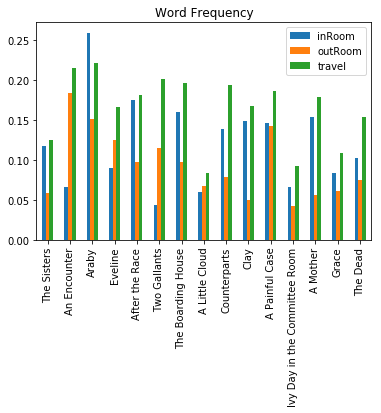

In [46]:
df = pd.DataFrame(storyRoom, index=titles).fillna(0).plot(kind='bar',title="Word Frequency")

For the extension of the word "street", I though of counting the indoor and outdoor nouns and compare the frequency.

I counted words which generally fall into three categories, indoor nouns, outdoor nouns and verbs describing travel. For nouns, I used the wordnet to get eight different types of words, room, furnishing, building, road, body_of_water, tract, geological_formation and physical phenomenon. The first three categories are indoor and the following five categories are outdoor. 

We can see that words included in "room" are high in "Araby" and "After the Race". At the beginning I was confused because there should have been a large proportion describing travel on road in these two chapters. Then I found "stalls" appears many times in araby and "cars" which represents a luxurious transportation at that time in "After the Race". Also, words included in "furnishing" is high in "Counterparts", because "desk" often appears in the office of the main characters’s boss and "table" appears several times in the arm-wrestling contest.

The physical_phenomenon is high in "An Encounter", "Araby", "A Painful Case", indicating plenty of outdoor activities. 

In "An Encounter" and "Araby", the travel verbs are a lot. "An Encounter" has highest outdoor nouns frequency and it seems very resonable. "Araby" has the highest indoor nouns because lots of stalls and houses are mentioned.

These groups of words reflect the distinctive contents in each chapter. 

### 4. Places in *Ulysses*

In [ ]:
url = "http://corpus-db.org/api/id/4300.0/fulltext"  #get the book Ulysses
response = requests.get(url)
book = json.loads(response.text)

In [34]:
words = nltk.word_tokenize(book[0]['text'])
nlp = spacy.load('en_core_web_lg')
uly = nlp(book[0]['text'][:1000000])

In [236]:
placewords = []                                 #get places that appear most frequently
for word in uly.ents:
    if word.label_ in ['GPE','FAC','LOC'] and word.text!='Lenehan':
        placewords.append(word.text)
collections.Counter(placewords).most_common(20)

[('Dublin', 61),
 ('Ireland', 53),
 ('Paris', 16),
 ('London', 15),
 ('Egypt', 13),
 ('earth', 11),
 ('Rome', 8),
 ('Kildare', 8),
 ('Europe', 8),
 ('England', 7),
 ('America', 7),
 ('Holles', 7),
 ('Stratford', 7),
 ('Cuckoo', 7),
 ('Liverpool', 6),
 ('Malahide', 6),
 ('Spain', 6),
 ('Venus', 6),
 ('Galway', 5),
 ('Howth', 5)]

In [40]:
for place in places_wholebook:
    if place in gpewords:
        print(place)

Sandymount
London
Romeo
Berlin
earth
Westland Row
Liverpool
Connacht
the Antient Concert Rooms
Paris
Belfast
Phoenix
Italy
Germany
Ireland
Dublin
Europe
England
Rotunda
Dublin Castle
Donnybrook
Kingstown
Canada
France
Rome
Pillar
Killarney
Shannon
Westmoreland
Milan
Liffey
the Isle of Man
Hungary


I found in *Dubliners*, "London" and "Paris" appear most frequently besides "Dublin" and "Ireland". So do them in James Joyce's another Dublin novel *Ulysses*. In *Dubliners*, Paris and London serve as ideal places compared to Ireland, especially in Chandler's words. He longed for escaping Dublin. James Joyce wanted to point out the paralysis in Irish society. People are negative and their spirituality is empty. 

*Dubliners* was published by a London publisher while *Ulysses* was published in Paris. I have not figured out whether there is some correlation between them and what Paris and London represent in *Ulysses* or what Paris and London mean for James Joyce. If I could finish reading *Ulysses*, it would be a point for further discussion. I also listed the places appearing both in *Dubliners* and *Ulysses* above. The analyses of the places and people names both in *Dubliners* and *Ulysses* could be tried.

In conclusion, there is a strong link between those geographic information and the content in *Dubliners*. The places could tell us where the novel is distinct from others. They track the thoughts of the narrators and the development of the plot. As an approach to the insight of Dublin culture, places assists the analysis of styles and motifs.

Bibliography
1. Joyce, James. Dubliners. Project Gutenberg, 2019.
2. Joyce, James. Ulysses. 1922.
3. Hamlin, Madeleine. "Geographies of Mobility in James Joyce’s Dubliners." *Literary Geographies*, vol. 2, no. 2, 2016, pp. 128-143.
4. Mulliken, Jasmine. "Mapping Dubliners Project." 2012, http://mappingdubliners.org. 
5. Shashaty, Jill. "Reading "Dubliners" Parabolically." *James Joyce Quarterly*, vol. 47, no. 4, 2010, pp. 213-229.